QPU sizes: {0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: 17, 7: 17, 8: 17, 9: 17, 10: 17, 11: 17, 12: 17, 13: 17, 14: 17, 15: 17}
{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: 17, 7: 17, 8: 17, 9: 17, 10: 17, 11: 17, 12: 17, 13: 17, 14: 17, 15: 17}


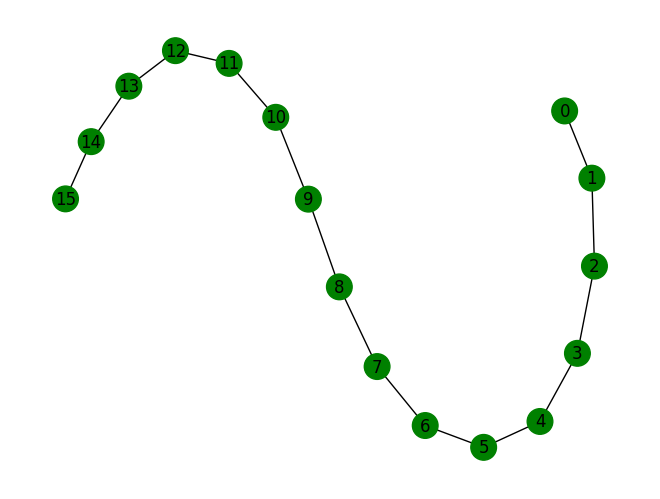

In [31]:
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions
from disqco.circuits.QAOA import QAOA_random
from qiskit.circuit.library import QFT, QuantumVolume  
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling, grid_coupling, random_coupling

import pickle

num_qubits = 256

circuit = QAOA_random(num_qubits, prob = 0.5, reps = 1)
# circuit = QFT(num_qubits,do_swaps = False)

circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.5)

# with open("circuit.pkl", "wb") as f:
#     pickle.dump(circuit, f)

# circuit = QuantumVolume(num_qubits, depth = num_qubits)

# with open("circuit.pkl", "rb") as f:
#     circuit = pickle.load(f)

# circuit = cz_fraction(  num_qubits=num_qubits,
                        # depth=num_qubits,
                        # fraction= 0.5)

# from QASMBench.interface.qiskit import QASMBenchmark

# # path to the root directory of QASMBench
# path = "QASMBench"
# # selected category for QASMBench
# category = "large" 
# # select only the circuits with the number of qubits in the list
# num_qubits_list = list(range(3, 200))
# # whether to remove the final measurement in the circuit
# remove_final_measurements = True
# # whether to use qiskit.transpile() to transpile the circuits (note: must provide qiskit backend)
# do_transpile = True  # Changed to True for transpiling circuits
# # arguments for qiskit.transpile(). backend should be provided at least
# transpile_args = { 'basis_gates': ['u', 'cp']}
# bm = QASMBenchmark(path, category, num_qubits_list=num_qubits_list, do_transpile=do_transpile, **transpile_args, remove_final_measurements=remove_final_measurements)
# for circuit in bm.circ_name_list:
#     print(circuit)
# circuit = bm.get('dnn_n51')

num_qubits = circuit.num_qubits

circuit = transpile(circuit, basis_gates = ['cp', 'u'])

# num_qubits = circuit.num_qubits

# print("Number of qubits:", num_qubits)


num_partitions = 16


import math



qpu_sizes = [int(num_qubits/num_partitions)+1]*num_partitions

qpu_sizes = {i : qpu_sizes[i] for i in range(num_partitions)}

print("QPU sizes:", qpu_sizes)


coupling = [[i, i+1] for i in range(num_partitions-1)]

# coupling = create_grid_coupling(num_partitions)

# coupling = None

# coupling = [[i, i+1] for i in range(num_partitions-1)]


# coupling = create_grid_coupling(num_partitions)
# coupling = [[i,j] for i in range(int(num_partitions/2)-1) for j in range(int(num_partitions/2)-1) if i != j]

# coupling += [[i,j] for i in range(int(num_partitions/2)+1,num_partitions) for j in range(int(num_partitions/2)+1,num_partitions) if i != j]
# coupling += [[int(num_partitions/2)-2, int(num_partitions/2)-1]]
# coupling += [[int(num_partitions/2)-1, int(num_partitions/2)]]
# coupling += [[int(num_partitions/2), int(num_partitions/2)+1]]

from networkx import erdos_renyi_graph


# graph = erdos_renyi_graph(num_partitions, 0.5)

# coupling = [[i,j] for i in range(num_partitions) for j in range(num_partitions) if i != j and graph.has_edge(i,j)]

# coupling = None

network = QuantumNetwork(qpu_sizes, coupling)

print(qpu_sizes)

network.draw()



In [32]:
graph = QuantumCircuitHyperGraph(circuit, group_gates = True, anti_diag = True)
assignment = set_initial_partitions(network=network, num_qubits=num_qubits, depth=graph.depth)
print(assignment)

from disqco.parti.FM.FM_methods import get_all_configs, get_all_costs_hetero

if num_partitions <=10:

    configs = get_all_configs(num_partitions, hetero=True)

    costs, edge_tree = get_all_costs_hetero(network, configs)
else:

    costs = {}

print(costs)

[[ 0  0  0 ... 14 14 15]
 [ 0  0  0 ... 14 14 15]
 [ 0  0  0 ... 14 14 15]
 ...
 [ 0  0  0 ... 14 14 15]
 [ 0  0  0 ... 14 14 15]
 [ 0  0  0 ... 14 14 15]]
{}


In [33]:
# from disqco.parti.FM.FM_hetero import run_FM_hetero

# final_cost, final_assignment, cost_list = run_FM_hetero(hypergraph=graph,
#                                                         initial_assignment=assignment,
#                                                         qpu_info=qpu_sizes,
#                                                         num_partitions=num_partitions,
#                                                         network=network,
#                                                         limit=num_qubits,
#                                                         costs=costs,
#                                                         passes=50,
#                                                         log=True)





In [34]:
from disqco.drawing.tikz_drawing import draw_graph_tikz
from disqco.drawing.mpl_drawing import draw_graph_mpl

%load_ext jupyter_tikz

# if num_qubits <= 32:
#     draw_graph_tikz(graph, assignment, qpu_sizes)
# else:
#     if num_qubits <= 64:
#         draw_graph_mpl(graph, assignment, qpu_sizes)

The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


In [35]:
# print("Final cost: ", final_cost)
import qiskit
qiskit.__version__

'1.2.4'

In [36]:
from disqco.parti.FM.multilevel_FM import MLFM_recursive_hetero

print(qpu_sizes)

final_assignment_list, final_cost_list, _ = MLFM_recursive_hetero(graph,
                                                                    assignment,
                                                                    qpu_sizes,
                                                                    limit=num_qubits,
                                                                    network=network,
                                                                    log=True,
                                                                    stochastic=True,
                                                                    costs=costs, 
                                                                    level_limit=None)





{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: 17, 7: 17, 8: 17, 9: 17, 10: 17, 11: 17, 12: 17, 13: 17, 14: 17, 15: 17}


KeyboardInterrupt: 

In [ ]:

import numpy as np

final_assignment = final_assignment_list[np.argmin(final_cost_list)]

counts = []

for layer in final_assignment:
    counts.append(np.bincount(layer))
    print(layer)

print(counts)
# if num_qubits <= 32:
#     fig = draw_graph_tikz(graph, final_assignment, qpu_sizes)
#     display(fig)
# else:
#      draw_graph_mpl(graph, final_assignment, qpu_sizes)

[ 9  3  7 10 13 12  8  8 13  5  4  4  5  1  7 13 11  1  1  1 14  3  8 13
  7  2 10  9  1 11  4  6 14 10 10  4  2  8  3  3  5  0  3 13 10 11  5 11
 12  0 14  0 11  6  7 11 11 13  7 12 12 12 12  2  0  0 14 14  8  7  6  7
  8  6  7 13  9  7  6  2  6 14  5  5  8  0  8  5  4  2 14  8 10  9  7  9
 14  5 14  4  2  1  8  9  7  2 15 12 11 12 10  6  0 11 14 13 11 12  4  5
  4  5 10  4  0  2 11 10  9  3  3  8 10 14  9  6 14  6 11  7 12 10  5  3
  5  7 11  9  9 12 13 13  1  4 13  1  5 10  9  1  8  7 13  2 15  0  3  9
 13 11 14  3  7 11  5  7  6 12  7  0 12 13 15 10  9  2  8  0  3  2  4  3
  3 10  1  9  3  4  8  5  2 11 10  6  1  6  8  6  9  2  4  1  1  4  3 12
  5 12 15 12 13  2 11  8  0  6  6  0  6 10  9  2 10 14 15 14  1  4  3  1
  5  6  8  9 12  4  2  2 13  1  4 15 13 14  3  1]
[ 9  3  7  6 13 12  8  8 10  5  4  4  5  1  7 13 11  1  1  1 14  3  8 13
  7  3 10  9  1  8  4  6 14 10 10  4  2  8  3  3  5  0  3 13 11 11  5 11
 12  0 14  0 11  6  7 11 11 14  7 12 12 12 12  2  0  0 14 14  8  7  6  7
 

In [ ]:
from disqco.parti.FM.multilevel_FM import MLFM_recursive

list_of_assignments, list_of_costs, _ = MLFM_recursive(
    graph,
    assignment,
    qpu_sizes,
    limit='qubit',
    log=True)

from disqco.graphs.hypergraph_methods import calculate_full_cost_hetero
import numpy as np

best_assignment = list_of_assignments[np.argmin(list_of_costs)]
print("best assignment", best_assignment)
cost_hetero = calculate_full_cost_hetero(graph, best_assignment, num_partitions, costs, network)

print(cost_hetero)

Initial cost: 14318


TypeError: unsupported operand type(s) for -=: 'list' and 'int'

In [ ]:
from disqco.utils.qiskit_to_op_list import circuit_to_gate_layers
layers = circuit_to_gate_layers(circuit)

for layer in layers:
    for gate in layer:
        print(gate)
        # print(gate.qargs)
        # print(gate.op.name)
        # print(gate.op.params)
        # print(gate.op.to_dict())
        # print(gate.op.to_matrix())
        # print(gate.op.to_instruction())
        # print(gate.op.to_gate())
        # print(gate.op.to_circuit())

['u', [0], ['q'], [0.7012971878187122, 0.19086122333620015, -3.039666662507355]]
['u', [1], ['q'], [2.277073342206281, 4.51405049051915, 4.322225133769666]]
['u', [2], ['q'], [1.9691082818655736, 2.8556811162621933, 1.3904069134071282]]
['u', [3], ['q'], [4.171061974716113, 5.194484802622908, 1.3677163555901826]]
['u', [4], ['q'], [2.330336945574337, -2.538575677580889, 1.4858518058899346]]
['u', [5], ['q'], [2.869539689807048, -0.2488417341128799, -0.5210526522424557]]
['u', [6], ['q'], [5.432635452259713, 2.0398158233712573, 1.1359578030832065]]
['u', [7], ['q'], [1.6858782534217738, -1.1292937513451733, -1.5503817788815053]]
['u', [10], ['q'], [6.114367342468417, 3.2142617480835383, 0.5628581168105423]]
['u', [11], ['q'], [0.7174481479337341, 2.203372556146542, 0.8797438487135265]]
['u', [12], ['q'], [1.496152376166758, 1.8732118756711327, 2.603118159026516]]
['u', [13], ['q'], [1.1890345439497316, 3.984335133684479, 3.9730881053372715]]
['u', [14], ['q'], [1.8463641979028451, 2.337